# Agent based modelling of social systems

### Modelling social awereness through a cognitive architecture model
Questions/Topics : 
* What is our question(clear formulation)-> Global awereness
* Topology of network
* Network generator (random?)
* Interaction of agents
* Literature
* Assumptions

### Structure
* Output: Plot Magnitude of event vs Importance of agent (color:fraction of agents, prob. to pass threshold)
* Model: 
 * P(k) distribution of #of outward lines
 * Interaction as a weighted relation of importance of agent and magnitude of event)
* Network: 
 * Random neighbour selection
 * % of neighbours interaction in each time step
* Events
 * Prob. distribution of events log(magn)= $\beta$ - $\gamma$log(occurences)
 * Decay as an exponential function
 * Global magnitude state of each event

In [1]:
import numpy as np
import igraph
import matplotlib.pyplot as plt
import random
from matplotlib import animation
from IPython.display import *
from PIL import Image
#%matplotlib inline

In [21]:
class SocialNet:
    def __init__(self, N):
        """
        Initialize the Graph with N number of agents and 
        give them a number of connections(links) from a 
        power law distribution -> scale-free network. Adjust 
        the size of each vertex to represent the number of
        links it has.
        """
        
        self.time=0
        self.N = N        
        self.g = igraph.Graph(self.N ,directed=True)
        self._create_agents()
        self.visual_style = {}
        self.visual_style["edge_arrow_size"] = 0.5
        layout = self.g.layout("lgl")
        self.visual_style["layout"] = layout
        self.visual_style["vertex_size"]=self.g.vs["size"]
        
        # All events stored in this list! First event is the null-event. All agents start with that.
        self.events=[Event(magnitude=0, t=0)]
    
    def _create_agents(self):
        """Sets attributes of vertices in Graph g"""
        for v in self.g.vs:
            
            # Initialize with null-event
            v["event_id"]=0
            v["event_magnitude"]=0
            
            # Generate number of links and format vertex based on that
            links = self.generate_followers() #self.scale_free_distr() 
            v["size"] = 5 + np.log(links)
            v["links"] = links
            
            if links > 5:
                v["type"] = "core"
                v["color"] = "slate blue"
            else:
                v["type"] = "peripheral"
                v["color"] = "SeaGreen2"  
            
            # Create actual links between agents 
            while links:
                source = v.index
                target = np.random.randint(0, len(self.g.vs))
                if not self.g.are_connected(source, target) and target!=source:
                    self.g.add_edge(source,target)
                    links-=1
                #self.g=self.g.simplify()
        
        for v in self.g.vs:
            v["importance"]= self.g.betweenness(v)
        return
    
    def generate_followers(self):
        chance=np.random.uniform(0,1)
        if chance>10**(-2.5):
            followers=10**( -0.88*np.log10(chance))
        elif chance>10**(-3):
            followers=10**( -2*np.log10(chance) -2.8)
        elif chance>10**(-5):
            followers=10**( -0.2*np.log10(chance)+2.6)
        else:
            followers=len(self.g.vs)-1
        return int(max(np.round(min(followers,len(self.g.vs)-1)),1))
    
    def scale_free_distr(self):
        """Power law distr P(k)=k^-2. In order to 
        limit the number of links possible distr is truncated
        at 0.001
        """
        p = np.random.rand()
        if p <= 0.001:
            return 1
        else:
            return int(np.round(1/np.sqrt(p)))
        
    def update(self):
        """Update all vertices by propagating the information and setting the new state"""
        # In each time-step events happen to agents.
        for v in self.g.vs:
            new_event = Event(agent_importance=v["importance"], t=self.time)
            # See whether new event is more interesting than old one
            if new_event.magnitude > v["event_magnitude"]:
                self.events.append(new_event)
                # event id is stored in Event object too
                self.events[-1].id = len(self.events)-1
                v["event_id"]=len(self.events)-1
                v["event_magnitude"]=new_event.magnitude    
                v["color"]=new_event.color
        
        # In each time-step agents communicate.
        """ Dynamics: event taken over deterministicly if it is larger event. Important: one-way comparison! """
        for v in self.g.vs:
            for neighbor in v.neighbors(mode=igraph.OUT):
                # only broadcast to a given proportion of neighbors
                if np.random.uniform(0,1)<0.5:
                    if neighbor["event_magnitude"]<v["event_magnitude"]:
                        neighbor["event_magnitude"]=v["event_magnitude"]
                        neighbor["event_id"]=v["event_id"]
                        neighbor["color"]=v["color"]
                # else do nothing    
               
        # At the end of each time-step decay all events and update all vertice event magnitudes
        # Also, calculate the total number of nodes thinking of event i and update event.awareness
        for single_event in self.events:
            single_event.decay()
            num = sum([v==single_event.id for v in self.g.vs["event_id"]])
            if num >= single_event.awareness:
                single_event.awareness = num
                single_event.final_time = self.time+1 #update final time
            
        for v in self.g.vs:
            v["event_magnitude"]=self.events[v["event_id"]].magnitude
                
        self.time+=1       
   
       
        
    def draw(self):        
        igraph.plot(self.g, "img/temp%i.png"%self.time, **self.visual_style)
        #display(Image(filename='img/temp%i.png'%self.time))
        
    """def displayPlot(self):
        plt.savefig("img/temp_plot.png")
        display(Image(filename='img/temp_plot.png'))"""

class Agent(igraph.Vertex):
    def __init__(self, name, num_links):
        self.attr = self.attributes()
        self.num_links = num_links
        self.visual_style["vertex_size"]=2*self.num_links
        self.visual_style["edge_arrow_size"] = 0.5
        self.event = 0
    def _create_links(self):
        pass
    def set_attributes(self):
        self.attr["size"] = int(self.num_links*2)
        
class Event:
    """ Single event. """
    def __init__(self,magnitude=None, agent_importance=1, t=0):
        self.id = None
        # This part is so that if I don't give any value, then the magnitude is generated
        if magnitude==None:
            magnitude=np.random.power(a=0.02)
        self.magnitude=magnitude
        self.initial_magnitude = magnitude
        self.color= "#%06x" % random.randint(0, 0xFFFFFF)
        self.agent_importance = agent_importance # each event contains initial agent importance
        self.awareness = 1 #max nr of agents thinking of event at a single time step
        self.init_time = t #time of event creation
        self.final_time = t # time of event peak
        
    def decay(self):
        # keep dt=1 for now since we have discrete time-steps
        gamma=0.01
        dt=1
        self.magnitude=self.magnitude*(1-gamma*dt)

In [52]:
Net=SocialNet(500)
int(np.round(min(1000000,len(Net.g.vs)-1)))

499

In [30]:
Net=SocialNet(500)
maxtime=1000
for i in range(maxtime):
    Net.update()
    print("updated", i)
    Net.draw()
    print("drawn", i)
    

t=1
fig = plt.figure()
img0 = Image.open('img/temp%i.png'%t)
im=plt.imshow(img0)
def updatefig(fake):
    global t
    img = Image.open('img/temp%i.png'%((t%maxtime)+1))
    im.set_data(img)
    t+=1
    return im
ani = animation.FuncAnimation(fig, updatefig, interval=300)
plt.show()

updated 0
drawn 0
updated 1
drawn 1
updated 2
drawn 2
updated 3
drawn 3
updated 4
drawn 4
updated 5
drawn 5
updated 6
drawn 6
updated 7
drawn 7
updated 8
drawn 8
updated 9
drawn 9
updated 10
drawn 10
updated 11
drawn 11
updated 12
drawn 12
updated 13
drawn 13
updated 14
drawn 14
updated 15
drawn 15
updated 16
drawn 16
updated 17
drawn 17
updated 18
drawn 18
updated 19
drawn 19
updated 20
drawn 20
updated 21
drawn 21
updated 22
drawn 22
updated 23
drawn 23
updated 24
drawn 24
updated 25
drawn 25
updated 26
drawn 26
updated 27
drawn 27
updated 28
drawn 28
updated 29
drawn 29
updated 30
drawn 30
updated 31
drawn 31
updated 32
drawn 32
updated 33
drawn 33
updated 34
drawn 34
updated 35
drawn 35
updated 36
drawn 36
updated 37
drawn 37
updated 38
drawn 38
updated 39
drawn 39
updated 40
drawn 40
updated 41
drawn 41
updated 42
drawn 42
updated 43
drawn 43
updated 44
drawn 44
updated 45
drawn 45
updated 46
drawn 46
updated 47
drawn 47
updated 48
drawn 48
updated 49
drawn 49
updated 50
drawn 50


In [25]:
fraction = np.asarray([e.agent_importance for e in Net.events])
plt.hist(fraction, bins=300)
plt.ylim([0,10])
plt.show()

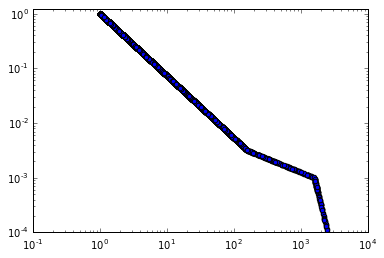

In [425]:
""" This cell is here so we can easily output plots of our distribution to show in the presentation. """
def generate_followers(follower_list, chance_list):
    chance=np.random.uniform(0,1)
    chance_list.append(chance)
    if chance>10**(-2.5):
        followers=10**( -0.88*np.log10(chance) )
    elif chance>10**(-3):
        followers=10**( -2*np.log10(chance) -2.8)
    elif chance>10**(-5):
        followers=10**( -0.2*np.log10(chance)+2.6 )
    else:
        followers=10**6.6
    follower_list.append(followers)
    return follower_list, chance_list

x_axis=[]
follower_list=[]
N=int(1e5)
for i in range(N):
    follower_list, x_axis= generate_followers(follower_list,x_axis)
"""fig=plt.figure()
ax = plt.gca()
ax.scatter(x_axis,follower_list)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(xmin=1e-4,xmax=1.2)"""


fig=plt.figure()
ax = plt.gca()
ax.scatter(follower_list,x_axis)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(ymin=1e-4,ymax=1.2)

In [70]:
""" The following two cells are just more standard ways that I tried to get the distributions,
but they didn't end up as nice as the hand-crafted one. You can go ahead and delete these, but 
I want to keep it for future reference in my copy. """
# bounds if I use linspace
a=1
b=10000

# bounds if I use logspace
c=1.5
d=5

spacing=100
exponent=-1.44

def CCDF(x, exponent, lower_bound, upper_bound):
    """ Exponent is exponent of pdf and can be negative. """
    return (1-(x**(exponent+1)-lower_bound**(exponent+1))/(upper_bound**(exponent+1)-lower_bound**(exponent+1)))

# Linspace
"""
ccdf_list=[CCDF(x,exponent,a,b) for x in np.linspace(a,b,spacing)]
plt.loglog(np.linspace(a,b,spacing),ccdf_list)
"""

# Logspace

ccdf_list=[CCDF(x,exponent,10**c,10**d) for x in np.logspace(c,d,spacing)]
plt.loglog(np.logspace(c,d,spacing),ccdf_list)

# Plot

plt.ylabel("CCDF")
plt.xlabel("magnitude of event/number of out-links")
plt.show()

In [73]:
# For twitter links:
c=1.5
d=5
spacing=100
exponent=-1.44
x_axis=np.logspace(c,d,spacing)
ccdf_list=[CCDF(x,exponent,10**c,10**d) for x in x_axis]

c=5
d=6.5
spacing=100
exponent=-0.01
temp_axis=np.logspace(c,d,spacing)
temp_axis=temp_axis[1:len(temp_axis)]
temp_list=[CCDF(x,exponent,10**c,10**d) for x in temp_axis]


for stuff in temp_list:
    ccdf_list=np.asarray(ccdf_list)
    ccdf_list=ccdf_list.tolist()
    ccdf_list.append(stuff)
for stuff in temp_axis:
    x_axis=np.asarray(x_axis)
    x_axis=x_axis.tolist()
    x_axis.append(stuff)

plt.loglog(x_axis,ccdf_list)
plt.show()

In [37]:
def analyze_events(events_list):
    magnitude = np.asarray([e.initial_magnitude for e in events_list])
    importance = np.asarray([e.agent_importance for e in events_list])
    awareness = np.asarray([e.awareness for e in events_list])
    colors = awareness/np.max(awareness)
    plt.scatter(importance, magnitude, c=colors, alpha=0.5)
    #plt.xscale('log')
    #plt.yscale('log')
    plt.colorbar()
    #plt.ylim([0,0.1])
    plt.show()
    return
    
    

In [41]:
plt.hist(np.asarray([e.initial_magnitude for e in Net.events]))
plt.show()
#analyze_events(Net.events)